In [8]:
from coffea import hist, processor
from coffea.analysis_objects import JaggedCandidateArray
import uproot
import numpy as np
import awkward as ak

class FancyDimuonProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 40, 0, 3500)

        self._accumulator = processor.dict_accumulator({
            'jtpt':hist.Hist("Counts", dataset_axis, pt_axis),
            'cutflow': processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()

        dataset = df['dataset']
        fjets = JaggedCandidateArray.candidatesfromcounts(
            df['nAK8Jets'],
            pt=df['AK8Jets_Pt'],
            eta=df['AK8Jets_Eta'],
            phi=df['AK8Jets_Phi'],
            mass=df['AK8Jets_M']
            )

        output['cutflow']['all events'] += fjets.size

        twofjets = (fjets.counts >= 2)

        difjets = fjets[twofjets].distincts()
        
        ptcut = ((difjets.i0['pt'] > 200 and difjets.i1['pt'] > 200))

        output['jtpt'].fill(dataset=dataset, pt=difjets.pt.flatten())

        return output

    def postprocess(self, accumulator):
        return accumulator

In [9]:
import time

tstart = time.time()

iD = "root://cmseos.fnal.gov//store/user/keanet/CondorOutput/tchannel/BkgNtuples/MCRoot/"

fileset = {
#     'DoubleMuon': [
#         'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root',
#         'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012C_DoubleMuParked.root',
#     ],
#     'ZZ to 4mu': [
#         'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/ZZTo4mu.root'
#     ],
    'QCD16': [
        iD+'QCD16_Pt_1000to1400.root',iD+'QCD16_Pt_120to170.root'
    ],
#     'Run2012B': [
#         'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root'
#     ],
#     'Run2012C': [
#         'root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012C_DoubleMuParked.root'   
#     ],

    
}

output = processor.run_uproot_job(
    fileset,
    treename='bkg_tree',
    processor_instance=FancyDimuonProcessor(),
    executor=processor.futures_executor,
    executor_args={'workers': 6, 'flatten': True},
    chunksize=50000,
)

elapsed = time.time() - tstart
print(output)

ValueError: no column named 'pt'

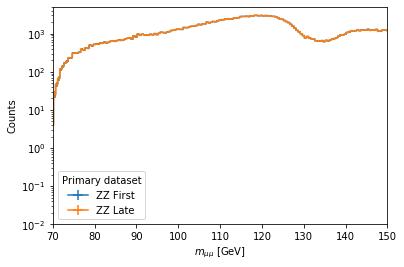

In [3]:
%matplotlib inline
ax = hist.plot1d(output['mass'], overlay='dataset')
ax.set_xlim(70,150)
ax.set_ylim(0.01, 5000)
ax.set_yscale("log")